#### 과제(3): 타이타닉 생존자 예측 모델을 아래 사항을 참조하여 개선하세요
- null값 처리
- 범주화
- 인코딩(원핫/레이블)

In [86]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
import seaborn as sns

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency
import re

from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

In [87]:
from sklearn.datasets import load_iris
from sklearn import datasets

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

In [88]:
from sklearn import tree
from sklearn.datasets import make_classification

from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier

In [89]:
df = pd.read_csv(r'C:\Users\h\hmkd1\mc_data\train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [90]:
print('### train 데이터 정보 ###  \n')
df.info()

### train 데이터 정보 ###  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [91]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 일괄 전처리 사용자 함수: trans()

In [92]:
### 일괄 전처리 ###

def name(df):
    arr = df.Name.values
    df['Name'] = [re.search(',\s([A-Za-z\s]+)[.]\s*', i)[1] for i in arr]   #직업/특징 데이터 뽑기
    return df

def nullskip(df):   #널값 처리
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    maxvalue = df['Embarked'].value_counts(dropna=True).idxmax()
    df['Embarked'].fillna(maxvalue, inplace=True)
    return df

def get_age(age):
    cat = ''
    if age < 5: cat='Baby'
    elif age < 15: cat= 'Child'
    elif age < 21: cat= 'Young Adult'
    elif age < 49: cat='Adult'
    elif age < 70: cat='Old'
    else: cat = 'Elder'
    return cat

def get_cate(fare):
    cat=''
    if fare<=15: cat='저가'
    elif fare<=60: cat='중가'
    elif fare<=200: cat='고가'
    else: cat='프리미엄'
    return cat

def drop_col(df):   #불필요한 속성(칼럼) 제거
    df['Family'] = df.SibSp + df.Parch
    df['Cabin'] = df['Cabin'].str[:1]
    
    df.drop(['PassengerId','Ticket','SibSp','Parch'], axis=1, inplace=True)
    return df

def format_enc(df):   #레이블 인코딩 수행
    features = ['Cabin','Sex','Embarked', 'Family', 'Age','Fare','Name']
    for i in features:
        le = LabelEncoder()
        le = le.fit(df[i])
        df[i] = le.transform(df[i])      
    return df
####################################################################
def trans(df):   #위에서 만들어둔 함수들 호출
    df = name(df)
    df = nullskip(df)
    df['Age'] = df.Age.apply(lambda x: get_age(x))
    df['Fare'] = df.Fare.apply(lambda x: get_cate(x))
    df = drop_col(df)
    df = format_enc(df)
    return df

### 필요없는 데이터 삭제 or 유효한 데이터로 변환

In [93]:
df['family'] = df.SibSp + df.Parch    #동승 가족 칼럼 생성
df.drop(['PassengerId','Ticket','SibSp','Parch'], axis=1, inplace=True)    #승객, 티켓번호 삭제

In [94]:
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,family
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,NaN,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C85,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,NaN,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,C123,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,NaN,S,0


In [95]:
arr = df.Name.values
df['job'] = [re.search(',\s([A-Za-z\s]+)[.]\s*', i)[1] for i in arr]   #직업/특징 데이터 뽑기
df.drop(['Name'], axis=1, inplace=True)   #이름 칼럼 삭제

# df.job.value_counts()     #직업/특징 종류

In [96]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,family,job
0,0,3,male,22.0,7.2500,NaN,S,1,Mr
1,1,1,female,38.0,71.2833,C85,C,1,Mrs
2,1,3,female,26.0,7.9250,NaN,S,0,Miss
3,1,1,female,35.0,53.1000,C123,S,1,Mrs
4,0,3,male,35.0,8.0500,NaN,S,0,Mr


In [97]:
# 객실 정보 삭제
af = df.drop(['Cabin'], axis=1)
af.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,family,job
0,0,3,male,22.0,7.2500,S,1,Mr
1,1,1,female,38.0,71.2833,C,1,Mrs
2,1,3,female,26.0,7.9250,S,0,Miss
3,1,1,female,35.0,53.1000,S,1,Mrs
4,0,3,male,35.0,8.0500,S,0,Mr


In [98]:
# 항구 최빈값으로 대체
maxvalue = af['Embarked'].value_counts(dropna=True).idxmax()
af['Embarked'].fillna(maxvalue, inplace=True)
af.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,family,job
0,0,3,male,22.0,7.2500,S,1,Mr
1,1,1,female,38.0,71.2833,C,1,Mrs
2,1,3,female,26.0,7.9250,S,0,Miss
3,1,1,female,35.0,53.1000,S,1,Mrs
4,0,3,male,35.0,8.0500,S,0,Mr


In [99]:
#### 나이 범주화
def get_age(age):
    cat = ''
    if age < 5: cat='Baby'
    elif age < 15: cat= 'Child'
    elif age < 21: cat= 'Young Adult'
    elif age < 49: cat='Adult'
    elif age < 70: cat='Old'
    else: cat = 'Elder'
    return cat

af['Age'] = af.Age.apply(lambda x: get_age(x))

#### 가격 범주화
def get_cate(fare):
    cat=''
    if fare<=15: cat='저가'
    elif fare<=60: cat='중가'
    elif fare<=200: cat='고가'
    else: cat='프리미엄'
    return cat

af['Fare']=af.Fare.apply(lambda x: get_cate(x))

In [100]:
af

,Survived,Pclass,Sex,Age,Fare,Embarked,family,job
0,0,3,male,Adult,저가,S,1,Mr
1,1,1,female,Adult,고가,C,1,Mrs
2,1,3,female,Adult,저가,S,0,Miss
3,1,1,female,Adult,중가,S,1,Mrs
4,0,3,male,Adult,저가,S,0,Mr
...,...,...,...,...,...,...,...,...
886,0,2,male,Adult,저가,S,0,Rev
887,1,1,female,Young Adult,중가,S,0,Miss
888,0,3,female,Elder,중가,S,3,Miss
889,1,1,male,Adult,중가,C,0,Mr


In [101]:
# 원핫 인코딩
ef = pd.get_dummies(af, columns=['job'])
ef = pd.get_dummies(ef, columns=['Sex'])
ef = pd.get_dummies(ef, columns=['Embarked'])
ef = pd.get_dummies(ef, columns=['Age'])
ef = pd.get_dummies(ef, columns=['Fare'])

In [102]:
ef

,Survived,Pclass,family,job_Capt,job_Col,job_Don,job_Dr,job_Jonkheer,job_Lady,job_Major,...,Age_Adult,Age_Baby,Age_Child,Age_Elder,Age_Old,Age_Young Adult,Fare_고가,Fare_저가,Fare_중가,Fare_프리미엄
0,0,3,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,1,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
887,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
888,0,3,3,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
889,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [103]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
df = pd.read_csv(r'C:\Users\h\hmkd1\mc_data\train.csv')

ydf = df['Survived']
xdf = ef.drop('Survived',axis=1)

In [104]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf,
                              test_size=0.2, random_state=121)

In [105]:
dtree = DecisionTreeClassifier(random_state=121)

dtree.fit(x_train , y_train)
pred = dtree.predict(x_test)

acc = accuracy_score(y_test, pred)
print(f'DecisionTreeClassifier 정확도: {acc:.4f}')

DecisionTreeClassifier 정확도: 0.7877


In [106]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dtree, xdf , ydf , cv=5)
count=0

for acc in scores:
    count+=1
    accuracy = accuracy_score(y_test, pred)
    print("교차 검증 {0}. 정확도: {1:.4f}".format(count, acc))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 1. 정확도: 0.7709
교차 검증 2. 정확도: 0.7865
교차 검증 3. 정확도: 0.7978
교차 검증 4. 정확도: 0.7865
교차 검증 5. 정확도: 0.7978
평균 정확도: 0.7879


In [107]:
parameters = {'max_depth':[1,5,10], 'min_samples_split':[2,3]}
gtree = GridSearchCV(dtree, param_grid=parameters, cv=3, refit=True)

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf,
                              test_size=0.2, random_state=121)
gtree.fit(x_train, y_train)

estimator = gtree.best_estimator_
pred = estimator.predict(x_test)
acc = accuracy_score(y_test,pred)

print('GridSearchCV 최적 파라미터:', gtree.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(gtree.best_score_))
print(f'테스트 데이터 세트 정확도: {acc:.4f}')

df = pd.DataFrame(gtree.cv_results_)
df[['params', 'mean_test_score', 'rank_test_score',
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

GridSearchCV 최적 파라미터: {'max_depth': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.8104
테스트 데이터 세트 정확도: 0.7877


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.800577,5,0.789916,0.810127,0.801688
1,"{'max_depth': 1, 'min_samples_split': 3}",0.800577,5,0.789916,0.810127,0.801688
2,"{'max_depth': 5, 'min_samples_split': 2}",0.810404,1,0.802521,0.801688,0.827004
3,"{'max_depth': 5, 'min_samples_split': 3}",0.810404,1,0.802521,0.801688,0.827004
4,"{'max_depth': 10, 'min_samples_split': 2}",0.804778,4,0.802521,0.810127,0.801688
5,"{'max_depth': 10, 'min_samples_split': 3}",0.806185,3,0.802521,0.814346,0.801688


#### 과제(1): 타이타닉 타이타닉 데이터셋에 대해 필요한 전처리 수행 후 랜덤포레스트 알고리즘을 적용, 평가, 성능개선(하이퍼 파라미터 튜닝/ 교재 218p)을 수행

In [144]:
# 일괄 전처리: trans() 함수
df = pd.read_csv(r'C:\Users\h\hmkd1\mc_data\train.csv')
df = trans(df)
df

,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Family
0,0,3,11,1,0,1,7,2,1
1,1,1,12,0,0,0,2,0,1
2,1,3,8,0,0,1,7,2,0
3,1,1,12,0,0,2,2,2,1
4,0,3,11,1,0,1,7,2,0
...,...,...,...,...,...,...,...,...,...
886,0,2,14,1,0,1,7,2,0
887,1,1,8,0,5,2,1,2,0
888,0,3,8,0,0,2,7,2,3
889,1,1,11,1,0,2,2,0,0


In [145]:
from sklearn.ensemble import RandomForestClassifier

ydf = df.Survived
xdf = df.drop('Survived', axis=1)

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, random_state=21)

rf = RandomForestClassifier()
rf.fit(x_train, y_train)

pred = rf.predict(x_test)
acc = accuracy_score(y_test, pred)
print(f'랜덤포레스트 정확도: {acc:.4f}')

랜덤포레스트 정확도: 0.7989


In [110]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [4,6,8,10],
    'min_samples_leaf': [1,3,5,6],
    'min_samples_split': [5,9,13,16],
    'n_estimators': [i for i in range(1,21)]  }

rf = RandomForestClassifier(random_state=21, n_jobs=-1)
grid = GridSearchCV(rf, param_grid=params, cv=5, n_jobs=-1)
grid.fit(x_train, y_train)

print(f'최적 하이퍼 파라미터: \n{grid.best_params_}')
# 각 파라미터 리스트 중 가장 최적의 값을 알려줌

print(f'최고 예측 정확도: {grid.best_score_}')

최적 하이퍼 파라미터: 
{'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 7}
최고 예측 정확도: 0.8440953412784399


#### 위에서 n_estimators값을 변화시켜 가며 출력
- 첫 번째 결과 -> 6,1,16,50
- 두 번재 결과 -> 8,3,5,10
- 세 번재 결과 -> 6,5,13,20
- 네 번째 결과 -> 6,3,13,7

In [146]:
# 위에서 나온 결과들 중 최적 찾기
hipa = [[50,6,1,16],[10,8,3,5],[20,6,5,13],[7,6,3,13]]
acc_li=[]

for i in hipa:
    new_rf = RandomForestClassifier(n_estimators=i[0],
                    max_depth=i[1], min_samples_leaf=i[2], min_samples_split=i[3],
                    random_state=21, n_jobs=-1)
    new_rf.fit(x_train, y_train)
    pred = new_rf.predict(x_test)

    acc = accuracy_score(y_test, pred)
    acc_li.append(acc)
    print(f'#<{len(acc_li)}> {i}일때, accuracy={acc}')

print(f'\n{acc_li.index(max(acc_li))+1}번 세트에서 accuracy={max(acc_li)}로 가장 큰 값을 가짐')

#<1> [50, 6, 1, 16]일때, accuracy=0.8044692737430168
#<2> [10, 8, 3, 5]일때, accuracy=0.8100558659217877
#<3> [20, 6, 5, 13]일때, accuracy=0.8156424581005587
#<4> [7, 6, 3, 13]일때, accuracy=0.8212290502793296

4번 세트에서 accuracy=0.8212290502793296로 가장 큰 값을 가짐


In [112]:
# max_features 조정하기 (1~8개)
for index,k in enumerate(hipa):
    acc_li=[]
    for i in range(1,8):
        new_rf = RandomForestClassifier(n_estimators=k[0], max_features=i,
                        max_depth=k[1], min_samples_leaf=k[2], min_samples_split=k[3],
                        random_state=21, n_jobs=-1)
        new_rf.fit(x_train, y_train)
        pred = new_rf.predict(x_test)

        acc_li.append(accuracy_score(y_test, pred))
    print(f"#<{index+1}> max_features={acc_li.index(max(acc_li))+1}일때, accuracy={max(acc_li)}로 가장 높음")
    
# 3번 세트의 max_features=3일때 정확도가 가장 높음

#<1> max_features=3일때, accuracy=0.8212290502793296로 가장 높음
#<2> max_features=1일때, accuracy=0.8268156424581006로 가장 높음
#<3> max_features=3일때, accuracy=0.8379888268156425로 가장 높음
#<4> max_features=4일때, accuracy=0.8268156424581006로 가장 높음


In [147]:
# 최종(3번 세트/ max_features=3)
new_rf = RandomForestClassifier(n_estimators=20, max_features=3,
            max_depth=6, min_samples_leaf=5, min_samples_split=13,
            random_state=21, n_jobs=-1)
new_rf.fit(x_train, y_train)
pred = new_rf.predict(x_test)

acc = accuracy_score(y_test, pred)
print(f'최적화를 마친 랜덤포레스트 정확도: {acc:.4f}')

최적화를 마친 랜덤포레스트 정확도: 0.8380


- n_estimators: 랜덤포레스트에서 결정트리 개수를 지정(디폴트=10)
    - 높을수록 성능 향상/ 단, 무조건은x 학습 수행시간이 오래 걸림
- max_features: 결정트리의 max_features 파라미터와 같음
    - 각 트리에서 분할할 때 고려할 특성(데이터의 열)의 최대 개수 지정
    - 정수로 주면 개수, 소수로 주면 %
    - 단, 랜덤포레스트 max_features는 디폴트값이 전체 피처의 sqrt(루트)
    - 클수록 더 복잡한 결정경계 설정이 가능하지만, 과적합 위험up
    - 작으면 모델의 안정성을 높이지만, 유용한 특성을 무시하게 될 수도
<br><br>

- max_depth: 트리의 최대 깊이를 제한
    - 너무 깊으면 과적합의 가능성o
    - 작은 값이 선택될수록, 모델이 더 일반화되어 예측 성능이 향상
- min_samples_leaf: 리프 노드가 가져야 하는 최소 샘플 수 지정
    - 큰 값을 설정할 수록 트리의 가지가 더 많이 생성 -> 세부적인 규칙이 생성되는 것을 방지 (트리의 복잡도 제어)
- min_samples_split: 노드를 분할하기 위해 필요한 최소 샘플 수 지정
    - 작게 설정할수록 모델이 더 복잡한 규칙을 학습할 수 있음
    - 너무 작으면 과적합 가능성o

### 유의!!!!
1. 학습할 때 정확도가 높았어도 검증 때 낮아질 수 있음
2. 튜닝 종류에 따라 정확도가 학습에서 높고, 검증에서 낮을 수 있음. 반대로 학습에서 낮고 검증에서 낮을 수도 있음
    - 학습세트 정확도만 보고 튜닝을 끝내지 말 것
3. 모델에 따라 같은 데이터셋이어도 정확도가 다 다름
    - 데이터 성격에 맞는, 데이터 분석 목적에 맞는, 튜닝 후 정확도에 따른 -> 모델을 적절히 선택

#### 과제(2): 과제1로부터 변수 중요도(feature_importances_ 5개만)를 도출하고 시각화하세요

In [148]:
new_rf = RandomForestClassifier(n_estimators=20, max_features=3,
                     max_depth=6, min_samples_leaf=5, min_samples_split=13,
                    random_state=21, n_jobs=-1)
new_rf.fit(x_train, y_train)
pred = new_rf.predict(x_test)

fi = new_rf.feature_importances_   #각 피처별 중요도 배열
dic = {}
for col, importances in zip(xdf.columns, fi):
    dic[col]=importances    #딕셔너리에 각 칼럼명-importance 넣기
top5 = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:5]   #상위 5개 칼럼만

x=[]; y=[]
print('# 변수 중요도(feature_importances) 상위 5개')
for i in top5:
    print(f'{i[0]}: {i[1]:.4f}')
    x.append(i[0]); y.append(i[1])

# 변수 중요도(feature_importances) 상위 5개
Sex: 0.3932
Name: 0.2082
Cabin: 0.1180
Pclass: 0.1027
Family: 0.0906


<AxesSubplot:>

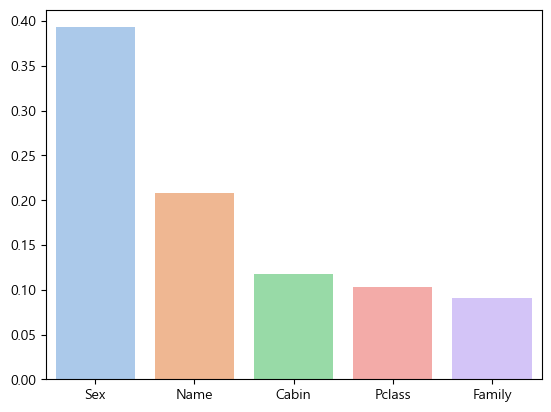

In [149]:
# 시각화
sns.barplot(x=x, y=y, palette="pastel")

#### 그래프 그리기(강사님)

<AxesSubplot:>

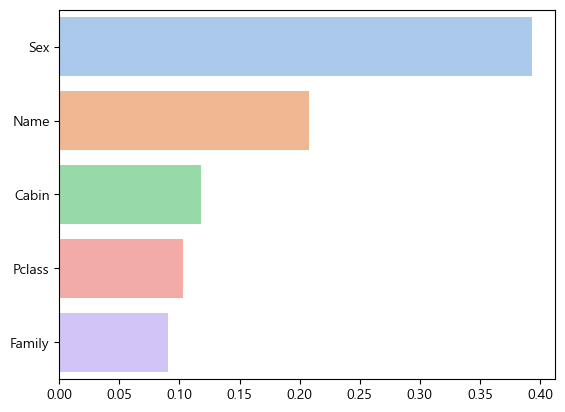

In [154]:
new_rf = RandomForestClassifier(n_estimators=20, max_features=3,
                     max_depth=6, min_samples_leaf=5, min_samples_split=13,
                    random_state=21, n_jobs=-1)
new_rf.fit(x_train, y_train)
pred = new_rf.predict(x_test)

fi_values = new_rf.feature_importances_   #각 피처별 중요도 배열

fi = pd.Series(fi_values, index=xdf.columns)   #각 값과 칼럼명
top5 = fi.sort_values(ascending=False)[:5]   #정렬해서 상위 5개

sns.barplot(x=top5, y=top5.index, palette="pastel")

#### 원래 과제 했던 방식(위에는 과제 점검하며 수정한 코드)

In [116]:
df = pd.read_csv(r'C:\Users\h\hmkd1\mc_data\train.csv')
df = trans(df)

ydf = df.Survived
xdf = df.drop('Survived', axis=1)

x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, random_state=21)

rf = RandomForestClassifier()
rf.fit(x_train, y_train)

pred = rf.predict(x_test)
acc = accuracy_score(y_test, pred)
print(f'랜덤포레스트 정확도: {acc:.4f}')

랜덤포레스트 정확도: 0.8101


In [117]:
params = {
    'max_depth': [4,6,8,10],
    'min_samples_leaf': [1,3,5,6],
    'min_samples_split': [5,9,13,16]  }

rf = RandomForestClassifier(n_estimators=100, max_features=0.5,
                           random_state=21, n_jobs=-1)
grid = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid.fit(x_train, y_train)

print(f'최적 하이퍼 파라미터: \n{grid.best_params_}')
# 각 파라미터 리스트 중 가장 최적의 값을 알려줌

print(f'최고 예측 정확도: {grid.best_score_}')

최적 하이퍼 파라미터: 
{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 9}
최고 예측 정확도: 0.8384831460674157


In [118]:
# 다양하게 줘 가며 params값 조정 -> 나온 결과로 rf 수정함
acc_li = []

# n_estimators 조정하기
for i in range(1,20):
    new_rf = RandomForestClassifier(n_estimators=i, max_features=0.5,
                    max_depth=6, min_samples_leaf=1, min_samples_split=9,
                    random_state=21, n_jobs=-1)
    new_rf.fit(x_train, y_train)
    pred = new_rf.predict(x_test)
    
    acc_li.append(accuracy_score(y_test, pred))
print(f"n_estimators={acc_li.index(max(acc_li))+1}일때, accuracy={max(acc_li)}로 가장 높음")

# 10~100까지 10씩 돌렸을 때 -> 10이 가장 높았음
# 1~20 돌렸을 때 -> 5, 7에서 가장 높음

n_estimators=5일때, accuracy=0.8324022346368715로 가장 높음


In [119]:
acc_li

[0.8044692737430168,
 0.8100558659217877,
 0.8268156424581006,
 0.8268156424581006,
 0.8324022346368715,
 0.8212290502793296,
 0.8324022346368715,
 0.8268156424581006,
 0.8268156424581006,
 0.8268156424581006,
 0.8268156424581006,
 0.8212290502793296,
 0.8156424581005587,
 0.8100558659217877,
 0.8100558659217877,
 0.8156424581005587,
 0.8100558659217877,
 0.8100558659217877,
 0.8156424581005587]

In [120]:
# max_features 조정하기 (1~8개)
acc_li=[]
for i in range(1,9):
    new_rf = RandomForestClassifier(n_estimators=5, max_features=i,
                    max_depth=6, min_samples_leaf=1, min_samples_split=9,
                    random_state=21, n_jobs=-1)
    new_rf.fit(x_train, y_train)
    pred = new_rf.predict(x_test)
    
    acc_li.append(accuracy_score(y_test, pred))
print(f"max_features={acc_li.index(max(acc_li))+1}일때, accuracy={max(acc_li)}로 가장 높음")
# 1~8 돌렸을 때 -> 1,2,4에서 가장 높음

max_features=1일때, accuracy=0.8324022346368715로 가장 높음


In [121]:
acc_li

[0.8324022346368715,
 0.8324022346368715,
 0.8156424581005587,
 0.8324022346368715,
 0.8156424581005587,
 0.8044692737430168,
 0.8044692737430168,
 0.8044692737430168]

In [122]:
# max_features 조정하기 (1~8개)
acc_li=[]
for i in range(1,9):
    new_rf = RandomForestClassifier(n_estimators=5, max_features=i,
                    max_depth=6, min_samples_leaf=1, min_samples_split=9,
                    random_state=21, n_jobs=-1)
    new_rf.fit(x_train, y_train)
    pred = new_rf.predict(x_test)
    
    acc_li.append(accuracy_score(y_test, pred))
print(f"max_features={acc_li.index(max(acc_li))+1}일때, accuracy={max(acc_li)}로 가장 높음")
# 1~8 돌렸을 때 -> 1,2,4에서 가장 높음

max_features=1일때, accuracy=0.8324022346368715로 가장 높음


In [123]:
# n_estimators = 5,7
# max_features = 1,2,4
# 위 조합들 중 최종 값 뽑기

for i in [5,7]:
    for j in [1,2,4]:
        new_rf = RandomForestClassifier(n_estimators=i, max_features=j,
                        max_depth=6, min_samples_leaf=1, min_samples_split=9,
                        random_state=21, n_jobs=-1)
        new_rf.fit(x_train, y_train)
        pred = new_rf.predict(x_test)

        acc = accuracy_score(y_test, pred)
        print(f'n_estimators={i}, max_features={j}일 때, 정확도={acc}')
        
# (5,1) (5,2) (5,4), (7,4) 일때 acc=0.8324022346368715 로 가장 높음
# n_estimators -> 높을수록 성능up -> 7
# max_features -> 클수록 복잡한 결정경계 설정 가능 -> 4

n_estimators=5, max_features=1일 때, 정확도=0.8324022346368715
n_estimators=5, max_features=2일 때, 정확도=0.8324022346368715
n_estimators=5, max_features=4일 때, 정확도=0.8324022346368715
n_estimators=7, max_features=1일 때, 정확도=0.8044692737430168
n_estimators=7, max_features=2일 때, 정확도=0.8212290502793296
n_estimators=7, max_features=4일 때, 정확도=0.8324022346368715


#### 과제(2): 과제1로부터 변수 중요도(feature_importances_ 5개만)를 도출하고 시각화하세요

In [124]:
new_rf = RandomForestClassifier(n_estimators=7, max_features=4,
                     max_depth=6, min_samples_leaf=1, min_samples_split=9,
                    random_state=21, n_jobs=-1)
new_rf.fit(x_train, y_train)
pred = new_rf.predict(x_test)

fi = new_rf.feature_importances_   #각 피처별 중요도 배열
dic = {}
for col, importances in zip(xdf.columns, fi):
    dic[col]=importances    #딕셔너리에 각 칼럼명-importance 넣기
top5 = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:5]   #상위 5개 칼럼만

x=[]; y=[]
print('# 변수 중요도(feature_importances) 상위 5개')
for i in top5:
    print(f'{i[0]}: {i[1]:.4f}')
    x.append(i[0]); y.append(i[1])

# 변수 중요도(feature_importances) 상위 5개
Sex: 0.3654
Name: 0.2110
Family: 0.1179
Pclass: 0.1124
Cabin: 0.0950


<AxesSubplot:>

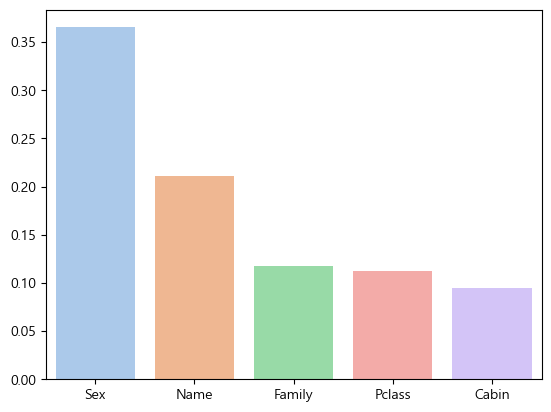

In [125]:
# 시각화
sns.barplot(x=x, y=y, palette="pastel")

#### 강사님 코드

In [126]:
titanic_df = pd.read_csv(r'C:\Users\h\hmkd1\mc_data\train.csv')

In [127]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(),inplace=True)
titanic_df['Cabin'].fillna('N',inplace=True)
titanic_df['Embarked'].fillna('N',inplace=True)
print('데이터 세트 Null 값 갯수 ',titanic_df.isnull().sum().sum())

데이터 세트 Null 값 갯수  0


In [128]:
print(' Sex 값 분포 :\n',titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n',titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n',titanic_df['Embarked'].value_counts())

 Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [129]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


In [130]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

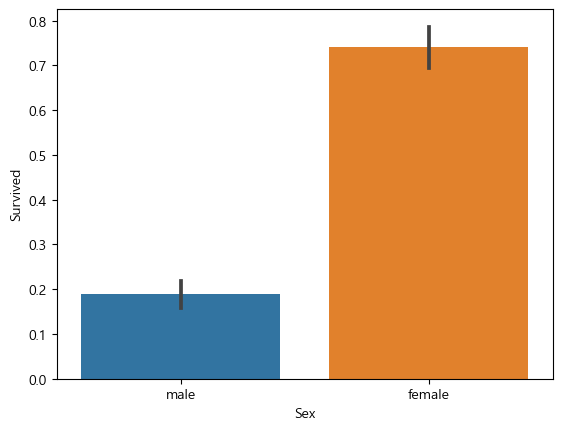

In [131]:
sns.barplot(x='Sex', y = 'Survived', data=titanic_df)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

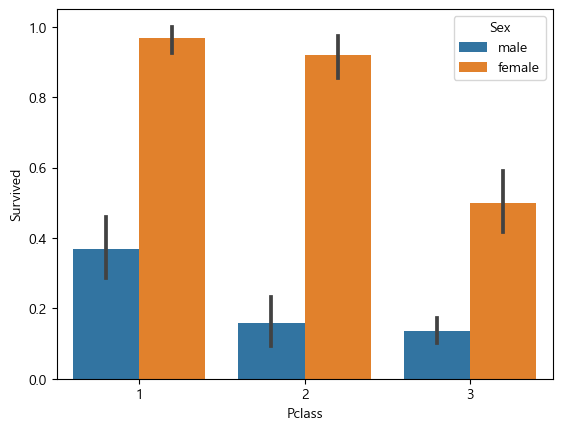

In [132]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

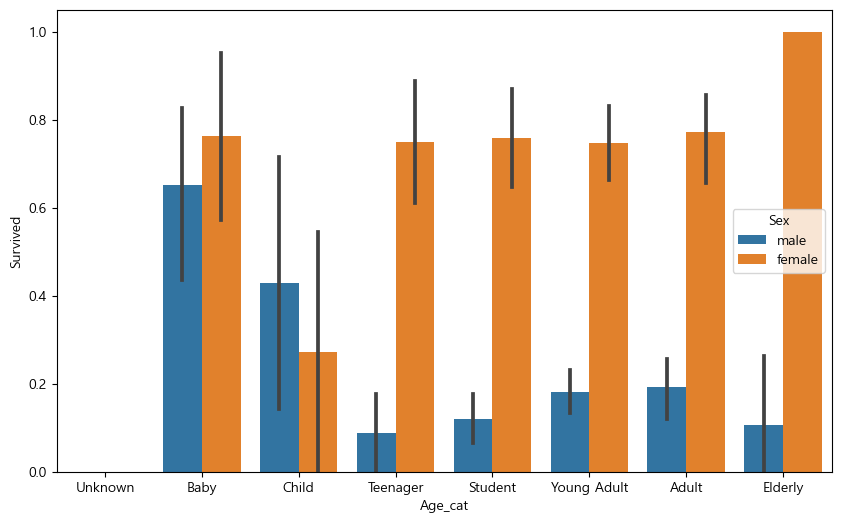

In [133]:
# 입력 age에 따라 구분값을 반환하는 함수 설정. DataFrame의 apply lambda식에 사용. 
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

# 막대그래프의 크기 figure를 더 크게 설정 
plt.figure(figsize=(10,6))

#X축의 값을 순차적으로 표시하기 위한 설정 
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category( ) 함수를 반환값으로 지정. 
# get_category(X)는 입력값으로 'Age' 컬럼값을 받아서 해당하는 cat 반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y = 'Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

In [134]:
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [135]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [136]:
# 원본 데이터를 재로딩 하고, feature데이터 셋과 Label 데이터 셋 추출. 
titanic_df = pd.read_csv(r'C:\Users\h\hmkd1\mc_data\train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived',axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, \
                                                  test_size=0.2, random_state=11)


In [138]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(solver='liblinear')

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train , y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train , y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train , y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))


DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도:0.8547
LogisticRegression 정확도: 0.8659


In [139]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
# exec_kfold 호출
exec_kfold(dt_clf , folds=5) 


교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [140]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf , param_grid=parameters , scoring='accuracy' , cv=5)
grid_dclf.fit(X_train , y_train)

print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행. 
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test , dpredictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy))


GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715
